<div style="line-height:0.5">
<h1 style="color:#BF66F2 "> Radial Basis Functions Networks in PyTorch </h1>
<h4>  </h4>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    nn.Dataset + np.random.uniform + torch.cat
</span>
</div>

<h3 style="color:#BF66F2 "> <b> Recap </b> </h3>
<div style="margin-top: -7px;">
The RBF transforms distances to activations in the range [0, 1] based on proximity to the center.

+ Distances very close to the center will result in activations near 1
+ Distances far from the center will result in activations near 0
+ The activations decay smoothly as the distance increases depending on the RBF shape
</div>

In [30]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [31]:
class RBF(nn.Module):
    """ Radial Basis Function network layer.\\
    Interpolate data using a given radial basis function:\\
        u_{i} = rbf(||x - c_{i}|| / s_{i})

    Parameters:
        - Size of each input sample [int]
        - Size of each output sample [int]
        - Radial basis function used to transform distances [callable, default is "guassian_basis_func"]

    Attributes:
        - Size of each input sample [int]
        - Size of each output sample [int]
        - Centers of radial basis functions: the learnable centres of shape []
        - Logarithm of RBF widths: logarithm of the learnable scaling factors of shape (out_features).
        - Radial basis used as activation function

    Methods:
        - reset_parameters: Initializes weights
        - forward: Computes layer output given input

    Details:
        The values are initialised from a standard normal distribution.\\
        Normalising inputs to have mean 0 and standard deviation 1 is recommended.
    """
    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        """ Initialize centres Normalizing using Gaussian distribution with std=1 and log_sigmas to 0. 
        """
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def forward(self, input):
        """ Computes RBF layer output given input.

        Details:
            - Define an appropriate size to use for matching the dimensions of the input and centers tensors
                - input.size(0) gets the batch size of the input tensor.
                - self.out_features is the number of RBF centers.
                - self.in_features is the dimension of each input sample.

            - Expand input to match dimensions of centres, broadcastsing input across the new dimension to match centres
                - unsqueeze(1) => Adds singleton dimension as the second dimension of the tensor

            - Compute pairwise squared Euclidean distance between input and centres
                - pow(2) to square the differences
                - sum(-1) to sum each row to calculate squared distance
                - pow(0.5) to take elementwise square root for the Euclidean distance

            - Divide distances (Elementwise division) by log variances
                Using logs makes the variances strictly positive during optimization and also makes the parameter space smoother
                    - torch.exp(self.log_sigmas) exponentiates the log variances (a nn.Parameter) to get the actual variances
                    - unsqueeze(0) adds singleton dimension for broadcasting, as the first dimension of the tensor

            Returns:
                Applied basis function [Matrix of shape (number of input samples x number of RBF units)]
        """
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5)
        distances = distances / torch.exp(self.log_sigmas).unsqueeze(0)

        return self.basis_func(distances)

<h2 style="color:#BF66F2 "> <b> Radial Basis Functions </b> </h2>

Gaussian polar:

 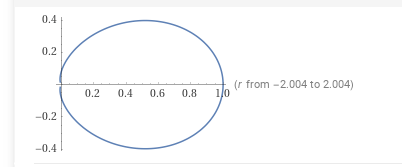

In [32]:
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

Quadratic polar:

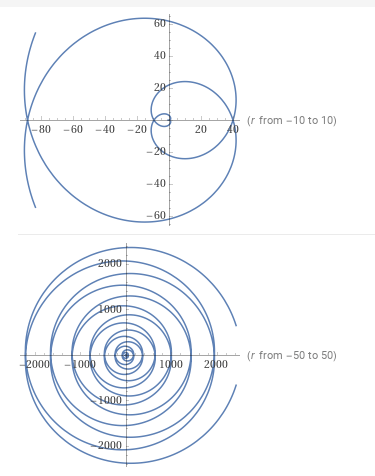

Multiquadratic polar:

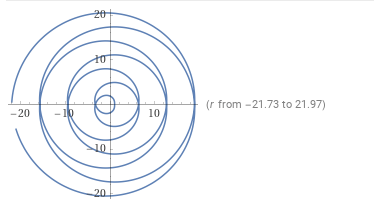



In [33]:
def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

Spline polar:

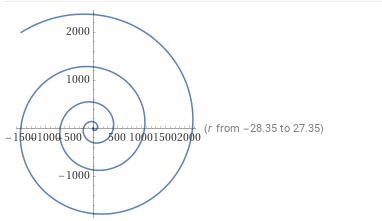

In [34]:
def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

Poisson 1 polar:

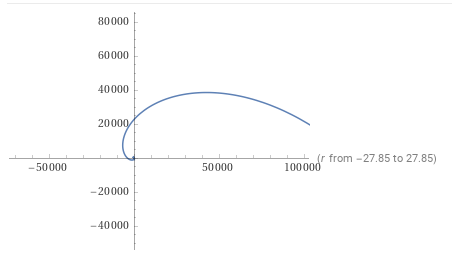

Poisson 2 polar:

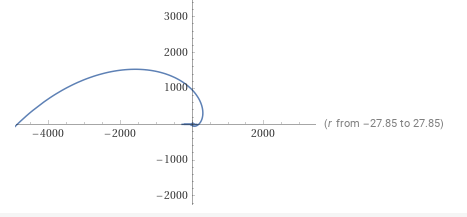

In [35]:
def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

<h3 style="color:#BF66F2 "> The general Matern RBF formula depends on two parameters: </h3>

$ \phi(r) = C * (1 +  \sqrt{(v)r}) * \exp(-\sqrt{(v)r}) $

The v value control smoothness, and can be adjusted to other values like 1/2, 3/2, 7/2



Matern 3/2 polar:

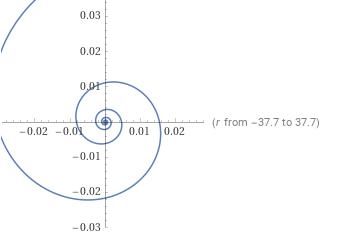

Matern 5/2 polar:


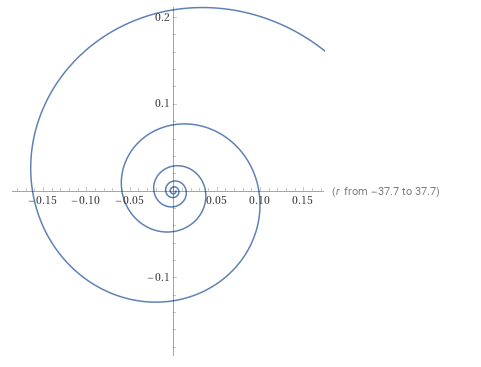

In [36]:
def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

In [37]:
def basis_func_dictionary ():
    """ Helper function that returns a dictionary containing each RBF function. """

    bases = {'gaussian': gaussian,
            'linear': linear,
            'quadratic': quadratic,
            'inverse quadratic': inverse_quadratic,
            'multiquadric': multiquadric,
            'inverse multiquadric': inverse_multiquadric,
            'spline': spline,
            'poisson one': poisson_one,
            'poisson two': poisson_two,
            'matern32': matern32,
            'matern52': matern52}
    return bases

<h2 style="color:#BF66F2 "> <b>Netwoork definition </b> </h2>

In [38]:
class MyDataset(Dataset):
    """ Custom Dataset class, used here as an abstraction to handle data loading and preprocessing in PyTorch.\\
    This class defines how to access and process the data, allowing efficient data loading in batches.\\
    DataLoader expects a Dataset object from which it can individually retrieve samples and their corresponding labels. \\

    Parameters:
        - x => Input data [torch.Tensor]
        - y => Output labels [torch.Tensor]

    Notes: it can be replaced simply using a TensorDataset from torch.utils.data
    """
    def __init__(self, x, y):
        """ Initialize the dataset. """
        self.x = x
        self.y = y

    def __len__(self):
        """ Get the length of the dataset as number of samples. """
        return self.x.size(0)

    def __getitem__(self, idx):
        """ Get a specific sample from the dataset (a tuple), given an index of the sample to retrieve. """
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

In [39]:
class Network(nn.Module):
    """ Neural Network class with RBF layers.

    Parameters:
        - Width of each layer [list of int]
        - Number of centers in each RBF layer [list of int]
        - Radial basis function to use [calleble]

    Attributes:
        - rbf_layers (nn.ModuleList): List of radial basis function (RBF) layers
        - linear_layers (nn.ModuleList): List of linear layers

    Methods:
        - forward(self, x): Forward pass through the network.
        - fit(self, x, y, epochs, batch_size, lr, loss_func): Train the network.

    """
    def __init__(self, layer_widths, layer_centres, basis_func):
        """ Initialize the network.

        Details:
            - Call the constructor of the parent class to initialize the base class
            - Initialize the lists that hold the radial basis function (RBF) layers
            - For all layer_widths, excluding the last element (subtract 1)
                - Append a new created RBF layer to the rbf_layers list with specified parameters
                - Append a new linear layer to the linear_layers list
                    - The linear layer is created using the Linear function from nn module
                    with:
                        - Input size: layer_centres[i]
                        - Output size: layer_widths[i+1]

        """
        super(Network, self).__init__()

        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()

        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))

    def forward(self, x):
        """ Forward pass through the network, to generate predictions from to input data.\\
        Determine how the network can transform input data into meaningful output, by overriding the nn.Module "forward" method.

        Parametrs:
            - Input data [torch.Tensor]

        Returns:
            - Network output [torch.Tensor]
        """
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out

    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        """ Train the network, learning patterns from the data to minimize the given loss function.\\
        Adjust the model's parameters (weights and biases) based on a training dataset.

        Parameters:
            - Input data [torch.Tensor]
            - Output labels [torch.Tensor]
            - Number of training epochs [int]
            - Batch size [int]
            - Learning rate [float]
            - Loss function to use

        Details:
            - Create a PyTorch Dataset to hold the training data (x, y)
            - Create a DataLoader to efficiently handle mini-batches
            - Create an Adam optimizer to update the model's parameters

            - For each training epoch:
                - Initialize the cumulative loss for the current epoch
                - Count the number of batches processed in the current epoch
                - Initialize a counter to track the progress within the current epoch

                - For each mini-batches in the training data
                    - Perform a forward pass to compute predictions (y_hat)
                    - Calculate the loss between predictions and target labels
                    - Update the cumulative loss for the current epoch
                    - Perform backpropagation to compute gradients

                    - Update the model's parameters using the optimizer
                    - Update the progress counter with the number of data points processed
                    - Update the progress information in the console

        """
        # Set the model to training mode
        self.train()

        # Total number of data points in the training set
        obs = x.size(0)
        trainset = MyDataset(x, y)

        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)

        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss, batches, progress = 0, 0, 0
            for x_batch, y_batch in trainloader:
                batches += 1
                # Zero the gradients to prepare for gradient accumulation
                optimiser.zero_grad()

                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1 / batches) * (loss.item() - current_loss)
                loss.backward()

                ### Update
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                            (epoch, progress, obs, current_loss))
                sys.stdout.flush()

<h2 style="color:#BF66F2 "> <b> Main </b> </h2>

The decision boundary function is given by:

$ x_2 = 0.5 \cdot \cos(\pi \cdot x_1) + 0.5 \cdot \cos(4 \pi \cdot (x_1 + 1)) $

For each sample...     

If the current sample index is in the first half, generate a random value for the second feature (x[i,1]), uniformly distributed between -1 and the value of the decision boundary function at x[i,0].

$ x[i,1] = \text{Uniform}(-1, 0.5 \cdot \cos(\pi \cdot x[i,0]) + 0.5 \cdot \cos(4 \pi \cdot (x[i,0] + 1))) $


If the current sample index is in the second half, generate a random value for the second feature (x[i,1]), uniformly distributed between the value <br> of the decision boundary function at x[i,0] and 1, placing the data points above the decision boundary in the second half.

$ x[i,1] = \text{Uniform}(0.5 \cdot \cos(\pi \cdot x[i,0]) + 0.5 \cdot \cos(4 \pi \cdot (x[i,0] + 1)), 1) $

In [40]:
""" Generate a dataset for a given decision boundary. """

samples = 200
# Array of 101 linearly spaced points between -1 and 1
x1 = np.linspace(-1, 1, 101)

# Define the decision boundary curve (based on the values of x1) using a combination of cosine functions
x2 = 0.5 * np.cos(np.pi * x1) + 0.5 * np.cos(4 * np.pi * (x1 + 1))

# Generate a random 2D array (samples by 2) with values uniformly distributed between -1 and 1,
# to represents the input data (features) for the classification problem
x = np.random.uniform(-1, 1, (samples, 2))

for i in range(samples):
    # Check if the current sample index is less than half of the total samples
    if i < samples // 2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

In [41]:
steps = 100
## Generate two 1D arrays of linearly spaced values from -1 to 1, with the specified number of steps
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
# Create a 2D grid (matrix) of x and y, with all combinations of x_span and y_span values
xx, yy = np.meshgrid(x_span, y_span)

#### Find the values:
    # => Reshape the xx and yy matrices into 1D arrays (vectors) and concatenate them horizontally.
    # => Create a 2-column array, where each row represents a coordinate (x, y).
    # => The ravel() function is used to flatten the matrix, preserving the original order of elements!
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                    yy.ravel().reshape(yy.ravel().shape[0], 1),
                    axis=1)

In [ ]:
""" Create the PyTorch tensors representing the inputs and target labels. 
# 1 => Convert the ndarray to a PyTorch tensor with float data type.
# 2 => Concatenate two tensors: one with zeros and the other with ones, to creates a tensor where the first half contains zeros, and the second half contains ones.
"""
tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)

In [42]:
tx.shape, ty.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

In this case the designed network receives a 2-dimensional input, transforms it into a 40-dimensional hidden representation with an RBF layer. <br>
It transforms that into a 1-dimensional output/prediction with a linear layer.

In [43]:
# Instanciate and train an RBF network with the Gaussian basis function
layer_widths = [2, 1]
layer_centres = [40]
basis_func = gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
# Train
rbfnet.fit(tx, ty, 5000, samples, 0.01, nn.BCEWithLogitsLoss())
# Set the model in evaluation mode
rbfnet.eval()

Epoch: 5000, Progress: 200/200, Loss: 0.002911      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

<h3 style="color:#BF66F2 "> Visualize the ideal and learned decision boundaries </h3>

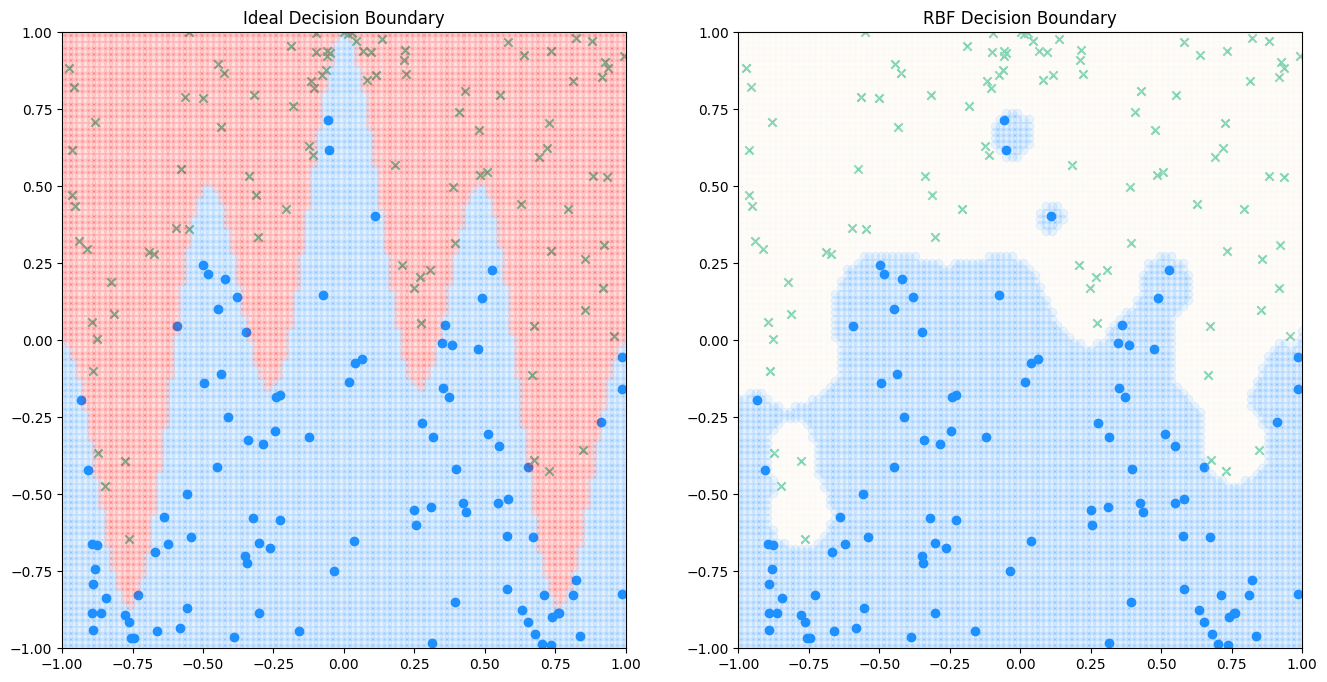

In [49]:
with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()

ideal_0 = values[np.where(values[:,1] <= 0.5 * np.cos(np.pi * values[:,0]) + 0.5 * np.cos(4 * np.pi * (values[:,0]+1)))[0]]
ideal_1 = values[np.where(values[:,1] > 0.5 * np.cos(np.pi * values[:,0]) + 0.5 * np.cos(4 * np.pi * (values[:,0]+1)))[0]]
area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='mediumaquamarine', marker='x')
ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='red')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_title('Ideal Decision Boundary')
ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='mediumaquamarine', marker='x')
ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='oldlace')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-1,1])
ax[1].set_title('RBF Decision Boundary')
plt.show()